In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-11-03 04:20:36--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.36.200, 52.216.110.253, 52.217.95.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.36.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.5MB/s    in 0.7s    

2024-11-03 04:20:37 (19.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

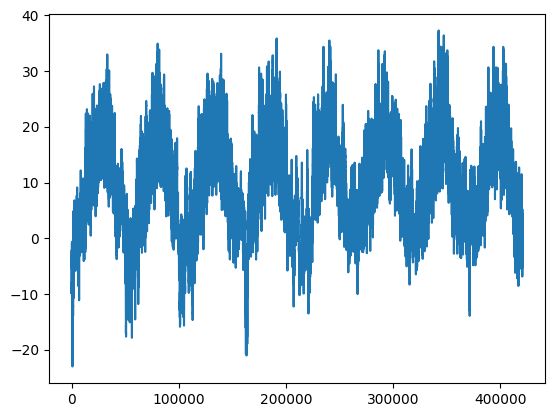

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

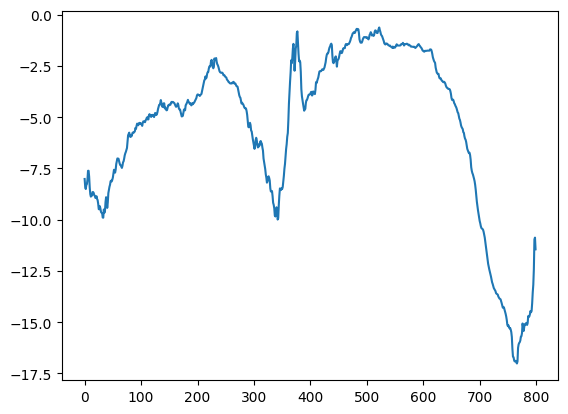

In [6]:
plt.plot(range(800), temperature[:800])

In [7]:

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [10]:
# Parameters
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

# Define the number of samples for train, validation, and test
num_train_samples = int(len(raw_data) * 0.7)  # 70% for training
num_val_samples = int(len(raw_data) * 0.15)  # 15% for validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples  # Remaining for test

# Create the train, validation, and test datasets
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.62
Test MAE: 2.51


Epoch 1/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 57s 45ms/step - loss: 57.2515 - mae: 5.5551 - val_loss: 15.7264 - val_mae: 2.8823
Epoch 2/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - loss: 10.7797 - mae: 2.4600 - val_loss: 12.4051 - val_mae: 2.7031
Epoch 3/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - loss: 7.4838 - mae: 2.0923 - val_loss: 12.3886 - val_mae: 2.7406
Epoch 4/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - loss: 6.0006 - mae: 1.8716 - val_loss: 12.9103 - val_mae: 2.8020
Epoch 5/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 79s 44ms/step - loss: 5.0899 - mae: 1.7194 - val_loss: 13.0246 - val_mae: 2.8013
Epoch 6/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - loss: 4.5117 - mae: 1.6159 - val_loss: 13.4141 - val_mae: 2.8408
Epoch 7/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - loss: 4.0692 - mae: 1.5317 - val_loss: 13.9269 - val_mae: 2.9170
Epoch 8/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - loss: 3.7702 - mae: 1.4746 - val_loss: 14.3249 - val_mae: 2.9499
Epoch 9/20
114

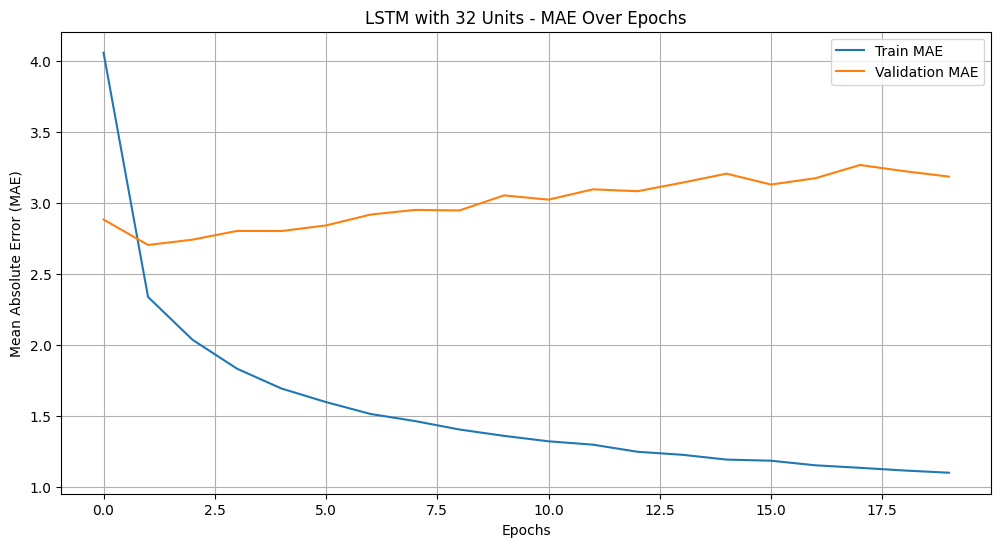

Model lstm with 32 units - Validation MAE: 3.184429883956909
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 13.8602 - mae: 2.9211
Test MAE for model lstm with 32 units: 2.9219717979431152
Epoch 1/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - loss: 56.4867 - mae: 5.5232 - val_loss: 15.8282 - val_mae: 2.8304
Epoch 2/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - loss: 11.5065 - mae: 2.5441 - val_loss: 11.5389 - val_mae: 2.5818
Epoch 3/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - loss: 8.2641 - mae: 2.2224 - val_loss: 10.8486 - val_mae: 2.5457
Epoch 4/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - loss: 6.9030 - mae: 2.0456 - val_loss: 11.3534 - val_mae: 2.6565
Epoch 5/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - loss: 5.8847 - mae: 1.8903 - val_loss: 11.9797 - val_mae: 2.7343
Epoch 6/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - loss: 5.0772 - mae: 1.7550 - val_loss: 12.6216 - val_mae: 2.8126
Epoch 7/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - loss: 4.452

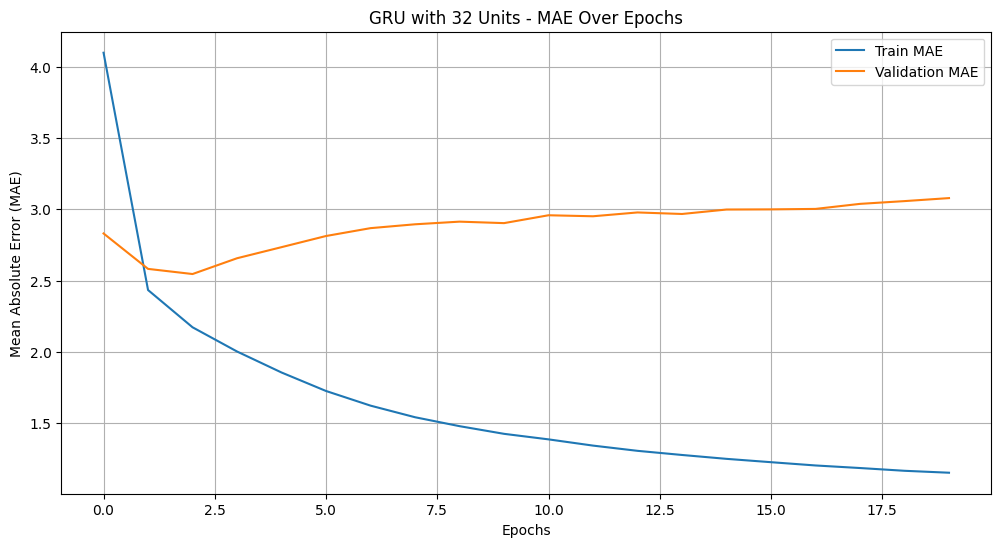

Model gru with 32 units - Validation MAE: 3.078643798828125
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 13.3151 - mae: 2.8767
Test MAE for model gru with 32 units: 2.8927574157714844
Epoch 1/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 58s 49ms/step - loss: 30.8937 - mae: 3.9392 - val_loss: 10.3834 - val_mae: 2.4368
Epoch 2/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - loss: 8.1838 - mae: 2.2260 - val_loss: 10.9316 - val_mae: 2.5672
Epoch 3/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 83s 49ms/step - loss: 5.9186 - mae: 1.8972 - val_loss: 14.1815 - val_mae: 2.9527
Epoch 4/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 81s 49ms/step - loss: 3.8874 - mae: 1.5345 - val_loss: 15.0366 - val_mae: 3.0337
Epoch 5/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 56s 49ms/step - loss: 2.8603 - mae: 1.3137 - val_loss: 15.1193 - val_mae: 3.0469
Epoch 6/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - loss: 2.2737 - mae: 1.1711 - val_loss: 15.6857 - val_mae: 3.1075
Epoch 7/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - loss: 1.9236 -

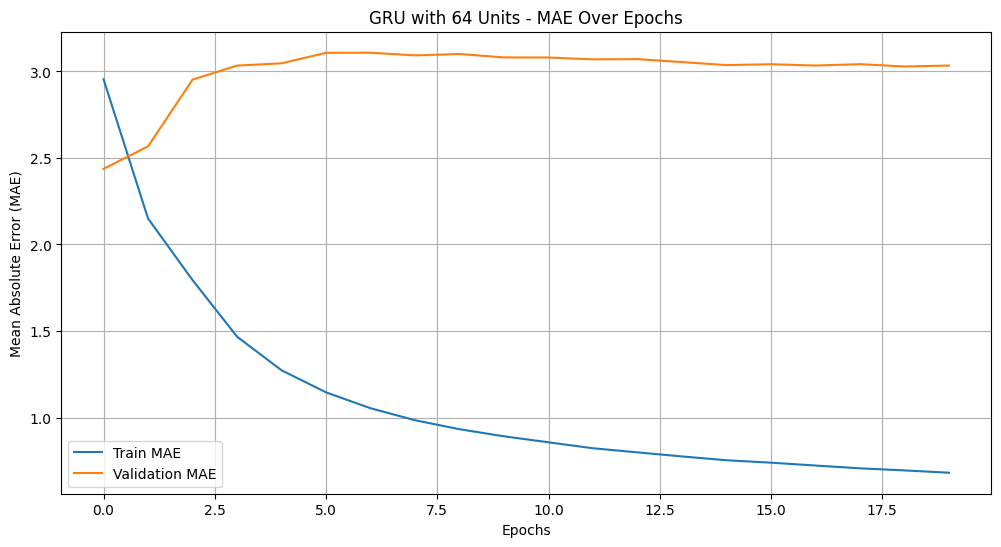

Model gru with 64 units - Validation MAE: 3.0338926315307617
241/241 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 12.9702 - mae: 2.8595
Test MAE for model gru with 64 units: 2.8699233531951904


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
# Define the model with Conv1D and LSTM/GRU layers
def create_model(rnn_type='lstm', rnn_units=32, use_conv=True):
    model = Sequential()

    # Optional Conv1D layer
    if use_conv:
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, raw_data.shape[1])))

    # Choose between LSTM and GRU
    if rnn_type == 'lstm':
        model.add(LSTM(rnn_units, return_sequences=True))
        model.add(LSTM(rnn_units // 2))  # Adding a second LSTM layer
    else:  # rnn_type is 'gru'
        model.add(GRU(rnn_units, return_sequences=True))
        model.add(GRU(rnn_units // 2))  # Adding a second GRU layer

    # Dense output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Train and evaluate different model configurations
results = []
test_results = []  # To store test results for all models

# Iterate over model configurations
for rnn_type in ['lstm', 'gru']:
    # LSTM only has 32 units
    if rnn_type == 'lstm':
        rnn_units_list = [32]
    else:  # GRU
        rnn_units_list = [32, 64]

    for rnn_units in rnn_units_list:
        model = create_model(rnn_type=rnn_type, rnn_units=rnn_units)
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

        # Plot the training and validation MAE
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['mae'], label='Train MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title(f'{rnn_type.upper()} with {rnn_units} Units - MAE Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error (MAE)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Store validation MAE for comparison
        val_mae = history.history['val_mae'][-1]
        results.append((rnn_type, rnn_units, val_mae))
        print(f"Model {rnn_type} with {rnn_units} units - Validation MAE: {val_mae}")

        # Evaluate the model on the test set
        test_loss, test_mae = model.evaluate(test_dataset)
        test_results.append((rnn_type, rnn_units, test_mae))
        print(f"Test MAE for model {rnn_type} with {rnn_units} units: {test_mae}")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 gru (GRU)                   (None, 120, 32)           4608      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 10977 (42.88 KB)
Trainable params: 10977 (42.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 59s 49ms/step - loss: 61.9302 - mae: 5.7856 - val_loss: 16.6090 - val_mae: 2.9562
Epoch 2/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 57s 50ms/step - loss: 10.9742 - mae: 2.4728 - val_loss: 12.4085 - val_mae: 2.7119
Epoch 3/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 80s 49ms/step - loss: 7.5995 - mae: 2.1119 - val_loss: 12.4224 - val_mae: 2.7407
Epoch 4/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 83s 49ms/step - loss: 6.4233 - mae: 1.9496 - val_loss: 11.9564 - val_mae: 2.7072
Epoch 5/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - loss: 5.4912 - mae: 1.8041 - val_loss: 12.4541 - val_mae: 2.7734
Epoch 6/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - loss: 4.8256 - mae: 1.6904 - val_loss: 13.1158 - val_mae: 2.8513
Epoch 7/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - loss: 4.2911 - mae: 1.5929 - val_loss: 13.2992 - val_mae: 2.8676
Epoch 8/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 57s 49ms/step - loss: 3.9805 - mae: 1.5359 - val_loss: 13.5647 - val_mae: 2.8923
Epoch 9/20
114

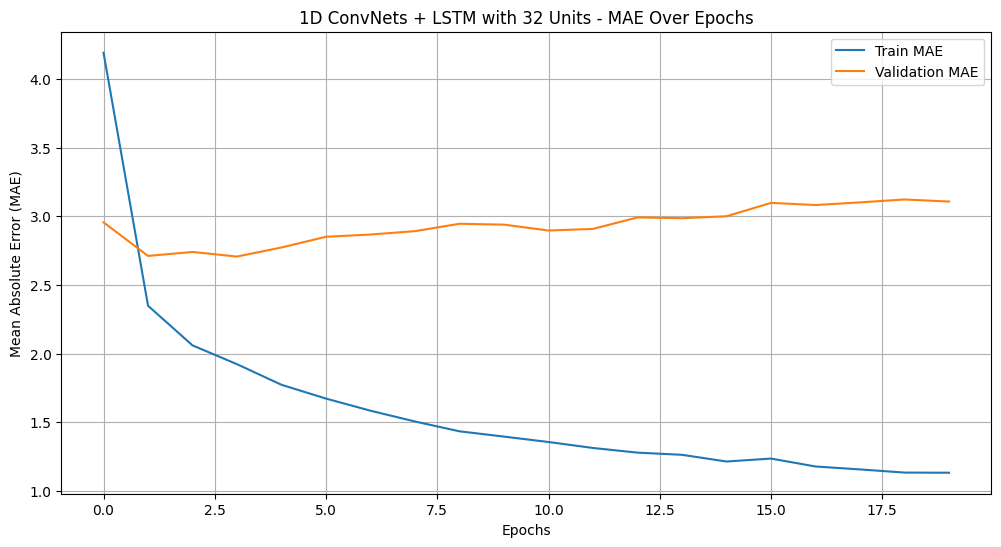

Model 1D ConvNets + LSTM with 32 units - Validation MAE: 3.1078224182128906
241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 14.6503 - mae: 3.0010
Test MAE for 1D ConvNets + LSTM with 32 units: 3.00567364692688

All test results:
Model lstm with 32 units - Test MAE: 2.9219717979431152
Model gru with 32 units - Test MAE: 2.8927574157714844
Model gru with 64 units - Test MAE: 2.8699233531951904


In [17]:
# Now for the combined model: 1D ConvNets + LSTM with 32 units
model = create_model(rnn_type='lstm', rnn_units=32, use_conv=True)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

# Plot the training and validation MAE for the combined model
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('1D ConvNets + LSTM with 32 Units - MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid(True)
plt.show()

# Store validation MAE for comparison
val_mae = history.history['val_mae'][-1]
results.append(('1d_convnets+lstm', 32, val_mae))
print(f"Model 1D ConvNets + LSTM with 32 units - Validation MAE: {val_mae}")

# Evaluate the combined model on the test set
final_test_loss, final_test_mae = model.evaluate(test_dataset)
print(f"Test MAE for 1D ConvNets + LSTM with 32 units: {final_test_mae}")

# Print all test results
print("\nAll test results:")
for config in test_results:
    print(f"Model {config[0]} with {config[1]} units - Test MAE: {config[2]}")

In [18]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 118, 32)             │           1,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 118, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,549 (150.59 KB)

 Trainable params: 12,849 (50.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,700 (100.39 KB)